In [1]:
import pandas as pd
import numpy as np
from pymoo.optimize import minimize

#%matplotlib qt
import PlotUtil
from notebooks.optimization_problems.constraints import Requirements
%load_ext autoreload

%autoreload 2

In [4]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "example_data.h5"

row_limit = -1

store_500km = pd.HDFStore(file_path)

instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_500km_df = instances_500km_df.sort_index(0)

In [5]:
N_passes = 20

instances_df = instances_500km_df.loc[0:N_passes,:]

In [48]:
from notebooks.optimization_problems.vcm_problem import VCMProblem
#from notebooks.optimization_problems.vcm_problem_parallel import VCMProblemPar
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters

import multiprocessing

# the number of processes to be used
# n_proccess = 8
# pool = multiprocessing.Pool(n_proccess)

sys_param = SystemParameters()
sys_param.margin_dB = 3.0
sys_param.Gtx_dBi_bounds = (3.0, 3.0)
sys_param.Ptx_dBm_bounds = (20., 70.)

modcods_df = pd.read_pickle('dvbs2.pkl')
sys_param.EsN0_req_dB_list = modcods_df['isend'].tolist()
sys_param.eta_bitsym_list = modcods_df['eta'].tolist()
sys_param.eta_maee_list = modcods_df['maee_12'].tolist()

requirements = Requirements()
requirements.min_throughput = 80e9

single_power = False
problem = VCMProblem(instances_df, sys_param, requirements=requirements, single_power=single_power)
#problem = VCMProblem(instances_df, sys_param, parallelization = ('starmap', pool.starmap))
#problem = VCMProblemPar(instances_df, sys_param)

sampling, crossover, mutation = design_vector_default_scm(problem.x_length, problem.x_indices)

converge_algo_settings = {'pop_size': 100, 'n_offsprings': 100}
unconverge_algo_settings = {'pop_size': 100, 'n_offsprings': 20}

converge_term_settings = {'f_tol': 0.0001, 'n_max_gen': 2000, 'n_max_evals': 200000}
unconverge_term_settings =  {'f_tol': 0.005, 'n_max_gen': 100, 'n_max_evals': 2000}

converge = True
if converge:
    algo_settings = converge_algo_settings
    term_settings = converge_term_settings
    postfix = '_converged'
else:
    algo_settings = unconverge_algo_settings
    term_settings = unconverge_term_settings
    postfix = '_unconverged'

from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    #x_tol=1e-8,
    #cv_tol=1e-6,
    f_tol=term_settings['f_tol'], #f_tol=0.005,
    nth_gen=100,
    n_last=30,
    n_max_gen=term_settings['n_max_gen'], #n_max_gen=1000,
    n_max_evals=term_settings['n_max_evals'], #n_max_evals=100000
)

from pymoo.algorithms.nsga2 import NSGA2

algorithm = NSGA2(
    pop_size=algo_settings['pop_size'],
    n_offsprings=algo_settings['n_offsprings'],
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)

res = minimize(problem,
               algorithm,
               termination=termination,
               seed=1,
               save_history=True,
               verbose=True
               )

#res = minimize(problem, GA())
# pool.close()
# problem.pool.close()

print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  1.79549E+10 |  5.87400E+10 |       1 |            - |            -
    2 |     200 |  1.51672E+10 |  4.59288E+10 |       1 |  2.78763E+09 |        ideal
    3 |     300 |  8.60318E+09 |  3.42900E+10 |       1 |  6.56406E+09 |        ideal
    4 |     400 |  2.23650E+08 |  2.51090E+10 |       1 |  8.37953E+09 |        ideal
    5 |     500 |  3.61000E+02 |  1.81919E+10 |       1 |  3.09872E+09 |        ideal
    6 |     600 |  1.56000E+02 |  1.19560E+10 |       1 |  2.32717E+09 |        ideal
    7 |     700 |  1.56000E+02 |  6.71400E+09 |       1 |  0.00000E+00 |            f
    8 |     800 |  1.54000E+02 |  2.69744E+09 |       1 |  6.04643E+09 |        ideal
    9 |     900 |  1.54000E+02 |  7.35353E+07 |       1 |  0.00000E+00 |            f
   10 |    1000 |  1.54000E+02 |  2.53330E+02 |       1 |  0.00000E+00 |            f
   11 |    1100 |  5.10000E+01 |  2.04950E+02 |       

C:\git\hermes-optimization\cenv\lib\site-packages\pymoo\operators\mutation\polynomial_mutation.py:34: RuntimeWarning: invalid value encountered in true_divide
  delta1 = (X - xl) / (xu - xl)
C:\git\hermes-optimization\cenv\lib\site-packages\pymoo\operators\mutation\polynomial_mutation.py:35: RuntimeWarning: invalid value encountered in true_divide
  delta2 = (xu - X) / (xu - xl)


KeyboardInterrupt: 

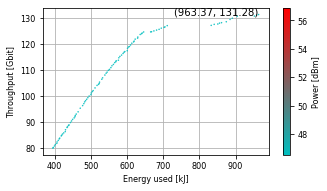

In [40]:
import colorcet as cc

from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
#from PlotUtil import apply_report_formatting, apply_report_formatting_single
import matplotlib.colors as mcol
import matplotlib.cm as cm

isend_req = 10.69

fig = plt.figure(figsize=(3.2, 2.4))

ax = fig.add_subplot(1,1,1)
ax.grid()
ax.set_axisbelow(True)

x_pass = res.X[:, problem.x_indices['pass']].astype('bool')

x_power = res.X[:, problem.x_indices['power']].astype('float64')

if single_power:
    x_power = x_power[:,0]
    min_Ptx = np.min(x_power)
    max_Ptx = np.max(x_power)
else:
    x_power[~x_pass] = np.nan
    min_Ptx = np.nanmin(np.nanmax(x_power, axis=1))
    max_Ptx = np.nanmax(np.nanmax(x_power, axis=1))

m = res.X[:, problem.x_indices['modcod']].astype('int64')

f_energy = res.F[:,1] / 1e3
f_throughput = ((res.F[:,0] * -1) / 1e9)   # Gigabit

cm1 = mcol.LinearSegmentedColormap.from_list("BlueRed",["c","r"])
#cm1 = mcol.LinearSegmentedColormap.from_list("BlueRed",["#4a569d","#dc2424"])
#cm1 = cc.cm.linear_kryw_5_100_c67_r
#cm1 = cc.cm.CET_L18

min_Ptx = np.nanmin(np.nanmax(x_power, axis=0 if single_power else 1))
max_Ptx = np.nanmax(np.nanmax(x_power, axis=0 if single_power else 1))

cnorm = mcol.Normalize(vmin=min_Ptx,vmax=max_Ptx)

cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])

cp = cpick.to_rgba(x_power.tolist() if single_power else np.nanmax(x_power, axis=1).tolist())
ax.scatter(f_energy, f_throughput, c=cp, marker='.', s=1)

ax.set_xlabel("Energy used [kJ]")
ax.set_ylabel("Throughput [Gbit]")
cb = plt.colorbar(cpick,label="Power [dBm]")
cb.ax.tick_params(labelsize=8)
cb.ax.yaxis.label.set_size(8)
#ax.set_ylim((0, 80))
#ax.set_xscale("log")
ax.text(np.max(f_energy), np.max(f_throughput),
        "(%.2f, %.2f)" % (np.max(f_energy), np.max(f_throughput)),
        horizontalalignment='right')
PlotUtil.apply_report_formatting(4.72, 2.76)
plt.tight_layout()

fig.savefig('D:/git/thesis_report_ae/figures/visibility_pareto%s.pdf' % postfix)
#plt.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.svg' % postfix)
plt.show()
plt.close()

In [ ]:
# fig = plt.figure(figsize=(3.2, 2.4))
#
# ax = fig.add_subplot(1,1,1)
# ax.grid()
# ax.set_axisbelow(True)
#
# x_power = res.X[:, problem.x_indices['power']]
# x_power = x_power[:,0]
#
# x_antenna = res.X[:, problem.x_indices['antenna']]
#
# f_energy = res.F[:,1]
# f_throughput = ((res.F[:,0] * -1) / 1e9)   # Gigabit
#
# ax.scatter(x_antenna, f_throughput, marker='.', s=1)
# ax.set_xlabel("Antenna gain [dBi]")
# ax.set_ylabel("Throughput [Gbit]")
# ax.set_xlim((5.5, 11))
# ax.set_ylim((0, 80))
#
# PlotUtil.apply_report_formatting(3.146, 2.76)
# plt.tight_layout()
#
# fig.savefig('D:/git/thesis_report_ae/figures/visibility_antenna_vs_throughput.pdf')

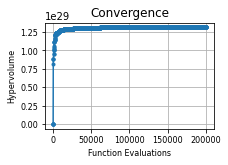

In [42]:
fig = plt.figure(figsize=(3.2, 2.4))

import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([0,1e18]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# function evaluations at each snapshot
n_evals = np.array([a.evaluator.n_eval for a in res.history])

# visualze the convergence curve
plt.plot(n_evals, hv, '-o', markersize=3)
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
PlotUtil.apply_report_formatting()
plt.tight_layout()
plt.grid()
#plt.savefig('D:/git/thesis_report_ae/figures/link_budget_hypervolume%s.svg' % postfix)
fig.savefig('D:/git/thesis_report_ae/figures/visibility_hypervolume%s.pdf' % postfix)
plt.show()
plt.close()
